## Import library

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  

## Define path & total number

In [2]:
path = "C:/users/cs623/.keras/datasets/personal_cats_and_dogs"
path_cat = os.path.join(path, 'cats')
path_dog = os.path.join(path, 'dogs')

In [3]:
num_cats = len(os.listdir(path_cat))
num_dogs = len(os.listdir(path_dog))
total_img_num = num_cats + num_dogs
print('total cat images:', num_cats)
print('total dog images:', num_dogs)
print('total images:', total_img_num)

total cat images: 1500
total dog images: 2172
total images: 3672


## Train test split

In [4]:
batch_size = 200
epochs = 50
IMG_HEIGHT = 150
IMG_WIDTH = 150
split = 0.2
total_val = total_img_num * split
total_train = total_img_num - total_val

In [5]:
# Generator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=split)

#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,

In [6]:
# Load images from the disk, applies rescaling, and resizes the images

train_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='validation') # set as validation data

Found 2938 images belonging to 2 classes.
Found 734 images belonging to 2 classes.


## Labels

In [7]:
import collections

def count_label(generator):
    l = len(generator)
    counter = collections.Counter()
    for i in range(l):
        _, label = generator[i]
        unique, counts = np.unique(label, return_counts=True)
        count_label = dict(zip(unique, counts))
        counter.update(count_label) 
    result = dict(counter)
    return result

In [8]:
train_count = count_label(train_generator)
val_count = count_label(validation_generator)

print("Training labels:")
print(train_count)
print("Validation labels:")
print(val_count)

Training labels:
{0.0: 1200, 1.0: 1738}
Validation labels:
{0.0: 300, 1.0: 434}


## Sample visualisation

In [9]:
sample_img_train, sample_label_train = next(train_generator)

In [10]:
def plotImg(img):
    fig, axes = plt.subplots(3, 5, figsize=(20, 20))
    axes = axes.flatten()
    for i, a in zip(img, axes):
        a.imshow(i)
        a.axis("off")
    plt.tight_layout()
    plt.show()

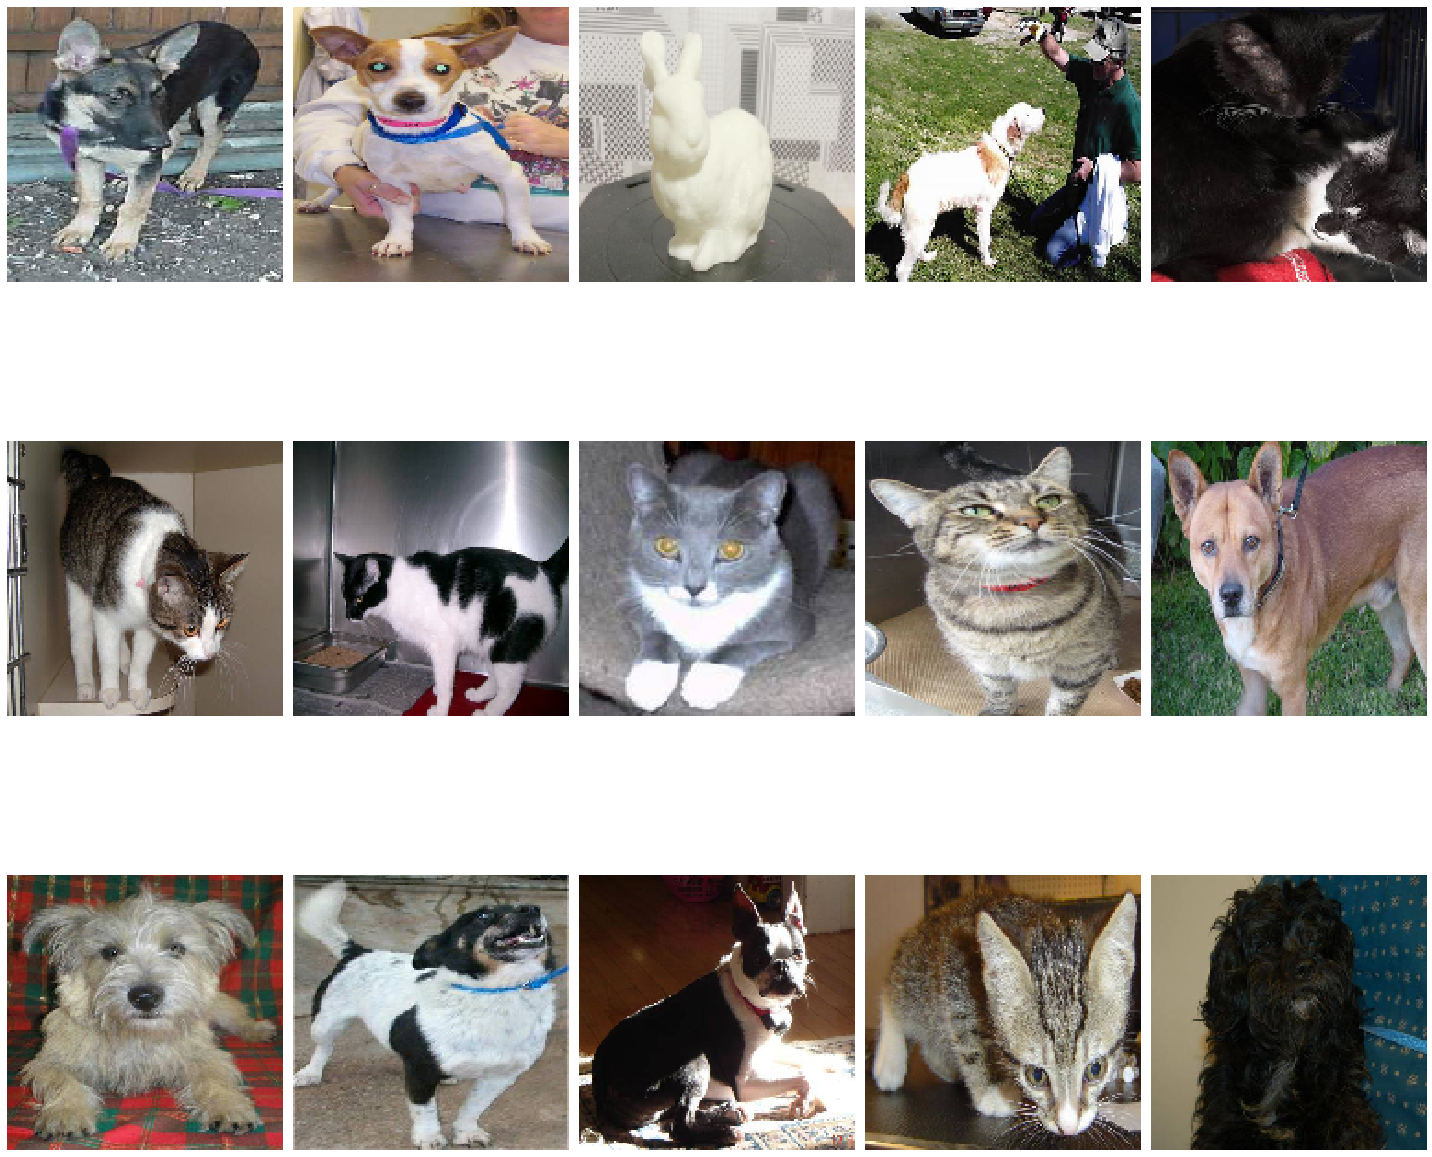

In [11]:
plotImg(sample_img_train[:15])

## Model

In [12]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

## Train model

In [15]:
with tf.device('/gpu:0'):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = total_train // batch_size,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = total_val // batch_size
    )
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Epoch 1/50
14/14 [==============================] - 20s 1s/step - loss: 0.8615 - acc: 0.5515 - val_loss: 0.6317 - val_acc: 0.5933
Epoch 2/50
14/14 [==============================] - 19s 1s/step - loss: 0.6442 - acc: 0.5909 - val_loss: 0.5763 - val_acc: 0.6400
Epoch 3/50
14/14 [==============================] - 21s 2s/step - loss: 0.6024 - acc: 0.6362 - val_loss: 0.4680 - val_acc: 0.7550
Epoch 4/50
14/14 [==============================] - 21s 2s/step - loss: 0.5626 - acc: 0.6830 - val_loss: 0.4247 - val_acc: 0.7683
Epoch 5/50
14/14 [==============================] - 21s 2s/step - loss: 0.5264 - acc: 0.7148 - val_loss: 0.3790 - val_acc: 0.8367
Epoch 6/50
14/14 [==============================] - 20s 1s/step - loss: 0.5105 - acc: 0.7290 - val_loss: 0.3933 - val_acc: 0.7967
Epoch 7/50
14/14 [==============================] - 21s 1s/step - loss: 0.4857 - acc: 0.7461 - val_loss: 0.4610 - val_acc: 0.7283
Epoch 8/50
14/14 [==============================] - 19s 1s/step - loss: 0.4650 - acc: 0.77

KeyboardInterrupt: 

## Result visualisation 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()